In [1]:
"""
Final Code for Binary Classification Using Handcrafted Features and ML Classifiers

This script:
• Clones the dataset from GitHub.
• Loads and preprocesses data using the provided method.
• Extracts handcrafted features from images.
• Trains both SVM and Neural Network classifiers.
• Evaluates the models with confusion matrices, overall metrics, and ROC-AUC curves.
• Saves the trained models and scaler.
"""

import os
import cv2
import numpy as np
import joblib
from skimage.feature import local_binary_pattern, hog
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ML and evaluation libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# ----------------------------
# Clone and Prepare Dataset
# ----------------------------
# Clone the repository and move the dataset folder
os.system("git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git")
os.system("mv Face-Mask-Detection/dataset .")

# Dataset parameters
dataset_path = "dataset"
img_size = (128, 128)
batch_size = 32
test_size = 0.2
val_size = 0.2

# ----------------------------
# Load and Preprocess Data
# ----------------------------
def load_data():
    classes = ['with_mask', 'without_mask']
    images = []
    labels = []

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = tf.keras.preprocessing.image.load_img(
                    img_path, target_size=img_size
                )
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                # Label: 0 for with_mask, 1 for without_mask
                labels.append(0 if class_name == 'with_mask' else 1)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    images = np.array(images)
    labels = np.array(labels)

    # Split data into train, test, and validation sets
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=test_size, stratify=labels, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, random_state=42
    )

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Load dataset
print("Loading dataset...")
(X_train_imgs, y_train), (X_val_imgs, y_val), (X_test_imgs, y_test) = load_data()
print("Dataset loaded.")
print(f"Train: {len(X_train_imgs)} images, Validation: {len(X_val_imgs)} images, Test: {len(X_test_imgs)} images")

Loading dataset...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Dataset loaded.
Train: 2620 images, Validation: 656 images, Test: 819 images


In [3]:
# ----------------------------
# Handcrafted Feature Extraction
# ----------------------------

def extract_features(image):
    """
    Extract handcrafted features from the input image:
    1. Edge density using Canny edge detector.
    2. Local Binary Pattern (LBP) texture histogram.
    3. Color histogram in HSV space.
    4. Histogram of Oriented Gradients (HOG) features.
    5. Skin segmentation ratio (using YCbCr color space).
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Feature 1: Edge Density
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / (edges.size + 1e-6)

    # Feature 2: LBP Texture
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 60), density=True)

    # Feature 3: Color Histogram (HSV)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist_hsv = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8],
                            [0, 256, 0, 256, 0, 256])
    hist_hsv = cv2.normalize(hist_hsv, hist_hsv).flatten()

    # Feature 4: HOG Descriptor
    hog_features = hog(gray, orientations=8, pixels_per_cell=(16, 16),
                       cells_per_block=(1, 1))

    # Feature 5: Skin Segmentation (YCbCr)
    ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    skin_mask = cv2.inRange(ycbcr, (0, 135, 85), (255, 180, 135))
    skin_ratio = np.sum(skin_mask == 0) / (skin_mask.size + 1e-6)

    # Concatenate all features into one vector
    features = np.concatenate([
        [edge_density],
        hist_lbp,
        hist_hsv,
        hog_features,
        [skin_ratio]
    ])
    return features

def compute_features(images):
    """
    Computes features for a list/array of images.
    The loaded images are in RGB format, so we convert them to BGR.
    """
    feats = []
    for img in tqdm(images):
        # Convert from RGB to BGR for OpenCV functions
        img_bgr = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR)
        # Resize image to ensure consistent dimensions (if not already)
        img_resized = cv2.resize(img_bgr, img_size)
        feat = extract_features(img_resized)
        feats.append(feat)
    return np.array(feats)

print("Extracting features for training set...")
X_train_feats = compute_features(X_train_imgs)
print("Extracting features for validation set...")
X_val_feats = compute_features(X_val_imgs)
print("Extracting features for test set...")
X_test_feats = compute_features(X_test_imgs)

# ----------------------------
# Normalize Features
# ----------------------------

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_feats)
X_val_norm = scaler.transform(X_val_feats)
X_test_norm = scaler.transform(X_test_feats)
joblib.dump(scaler, 'scaler.pkl')

Extracting features for training set...


100%|██████████| 2620/2620 [00:25<00:00, 101.98it/s]


Extracting features for validation set...


100%|██████████| 656/656 [00:05<00:00, 127.55it/s]


Extracting features for test set...


100%|██████████| 819/819 [00:06<00:00, 119.26it/s]


['scaler.pkl']

Training SVM classifier...
SVM Classification Report:
              precision    recall  f1-score   support

        mask       0.91      0.97      0.94       433
     no_mask       0.96      0.89      0.93       386

    accuracy                           0.93       819
   macro avg       0.94      0.93      0.93       819
weighted avg       0.93      0.93      0.93       819

Best SVM Parameters: {'C': 10, 'gamma': 0.001}


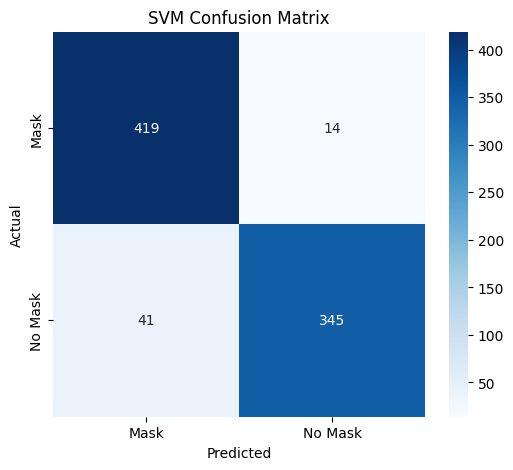

SVM Overall Metrics:
Accuracy: 0.9328 | Precision: 0.9359 | Recall: 0.9307 | F1-score: 0.9323


In [4]:
# ----------------------------
# Train SVM Classifier
# ----------------------------

print("Training SVM classifier...")
svm = SVC(kernel='rbf', class_weight='balanced', probability=True)
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1]}
grid = GridSearchCV(svm, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_norm, y_train)

# Evaluate SVM
y_svm_pred = grid.predict(X_test_norm)
y_svm_prob = grid.predict_proba(X_test_norm)[:, 1]  # Probability for positive class

print("SVM Classification Report:")
print(classification_report(y_test, y_svm_pred, target_names=["mask", "no_mask"]))
print("Best SVM Parameters:", grid.best_params_)

# Save SVM model
joblib.dump(grid.best_estimator_, '/content/drive/MyDrive/VR  Mini Project/Hand Crafted Feature data/mask_svm_classifier.pkl')

# Plot SVM Confusion Matrix
cm_svm = confusion_matrix(y_test, y_svm_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Mask", "No Mask"], yticklabels=["Mask", "No Mask"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

accuracy_svm = accuracy_score(y_test, y_svm_pred)
precision_svm = precision_score(y_test, y_svm_pred, average="macro")
recall_svm = recall_score(y_test, y_svm_pred, average="macro")
f1_svm = f1_score(y_test, y_svm_pred, average="macro")
print(f"SVM Overall Metrics:\nAccuracy: {accuracy_svm:.4f} | Precision: {precision_svm:.4f} | Recall: {recall_svm:.4f} | F1-score: {f1_svm:.4f}")

In [ ]:
# ----------------------------
# Train Neural Network Classifier
# ----------------------------

# Define Neural Network model (input dimension should match feature vector length, e.g., 1085)
print("Training Neural Network classifier...")
model = keras.Sequential([
    layers.Input(shape=(X_train_norm.shape[1],)),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model using validation set for NN training
history = model.fit(X_train_norm, y_train, epochs=30, batch_size=32,
                    validation_data=(X_val_norm, y_val))

# Save Neural Network model
model.save("/content/drive/MyDrive/VR  Mini Project/Hand Crafted Feature data/mask_nn_classifier.h5")

# Evaluate Neural Network
y_nn_prob = model.predict(X_test_norm).ravel()
y_nn_pred = (y_nn_prob > 0.5).astype(int)

print("Neural Network Classification Report:")
print(classification_report(y_test, y_nn_pred, target_names=["mask", "no_mask"]))

# Plot Neural Network Confusion Matrix
cm_nn = confusion_matrix(y_test, y_nn_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Mask", "No Mask"], yticklabels=["Mask", "No Mask"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Neural Network Confusion Matrix")
plt.show()

accuracy_nn = accuracy_score(y_test, y_nn_pred)
precision_nn = precision_score(y_test, y_nn_pred, average="macro")
recall_nn = recall_score(y_test, y_nn_pred, average="macro")
f1_nn = f1_score(y_test, y_nn_pred, average="macro")
print(f"Neural Network Overall Metrics:\nAccuracy: {accuracy_nn:.4f} | Precision: {precision_nn:.4f} | Recall: {recall_nn:.4f} | F1-score: {f1_nn:.4f}")

Training Neural Network classifier...
Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8310 - loss: 0.3763 - val_accuracy: 0.9207 - val_loss: 0.2220
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9783 - loss: 0.0688 - val_accuracy: 0.9345 - val_loss: 0.3570
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9941 - loss: 0.0192 - val_accuracy: 0.9390 - val_loss: 0.3538
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9979 - loss: 0.0066 - val_accuracy: 0.9375 - val_loss: 0.4863
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9977 - loss: 0.0084

In [ ]:
# ----------------------------
# ROC-AUC Curve for SVM
# ----------------------------
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_svm_prob)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {roc_auc_svm:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-AUC Curve: SVM Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# ----------------------------
# ROC-AUC Curve for Neural Network
# ----------------------------
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_nn_prob)
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {roc_auc_nn:.4f})", color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-AUC Curve: Neural Network Classifier")
plt.legend(loc="lower right")
plt.grid()
plt.show()
